# ***风格迁移***

# 0. 要解决的问题

① 目前你研究的大多数算法都会优化损失函数以获得一组参数值。而在神经样式转换中，你将学习优化损失函数以获得像素值！

② 接下来，你将：

 - 实现神经风格迁移算法

 - 使用算法生成新颖的艺术图像

① 神经风格迁移（NST）是深度学习中最有趣的技术之一。

② 如下所示，它将“内容”图像（Content）和“风格”图像（Style）合并在一起，以创建“生成”图像（Generated）。生成的图像G将图像C的“内容”与图像S的“风格”组合在一起。

③ 在此示例中，你将巴黎卢浮宫博物馆的图像（内容图像C）与印象派运动的领导者克劳德·莫奈的作品（风格图像S）混合在一起以生成新的图像。

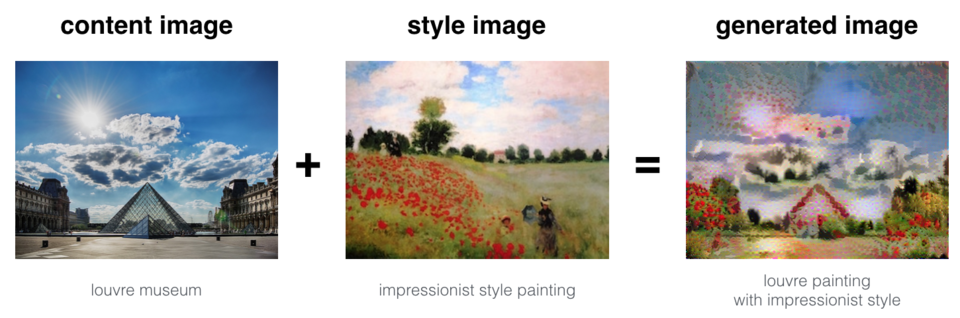

# 1. 导入库

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# 2. 迁移学习

① 神经风格迁移（NST）使用以前训练过的卷积网络，并以此为基础。

② 将之前经过不同任务训练的网络应用于新任务的想法叫做迁移学习。

① 遵循原始的NST论文，我们将使用VGG网络。

② 具体来说，我们将使用VGG-19，这是VGG网络的19层版本。

③ 该模型已经在非常大的ImageNet数据库上进行了训练，因此已经学会了识别各种低层特征和高层特征。

④ 运行以下代码以从VGG模型加载参数。这可能需要几秒钟。

In [2]:
model = load_vgg_model("datasets/imagenet-vgg-verydeep-19.mat")

print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

① 该模型存储在python字典中，其中每个变量名称都是键，而对应的值是包含该变量值的张量。

② 要通过此网络测试图像，只需要将图像提供给模型。

③ 在TensorFlow中，你可以使用 tf.assign函数执行此操作。

④ 特别地，你将使用如下的assign函数：

 - model["input"].assign(image) #tf.assign函数用法
 
⑤ 这会将图像分配为模型的输入。

⑥ 此后，如果要访问特定层的激活函数，例如当网络在此图像上运行时说4_2 层，则可以在正确的张量conv4_2上运行TensorFlow会话，如下所示：

 - sess.run(model["conv4_2"]) #访问 4_2 层的激活

# 3. 构建神经风格迁移

① 我们将分三步构建NST算法：

 - 建立内容损失函数$J_{content}(C,G)$；
 - 建立风格损失函数$J_{style}(S,G)$；
 - 放在一起得出$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

## 3.1 计算内容损失

① 在我们的运行示例中，内容图像C是巴黎卢浮宫博物馆的图片。

② 运行下面的代码以查看卢浮宫的图片。

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


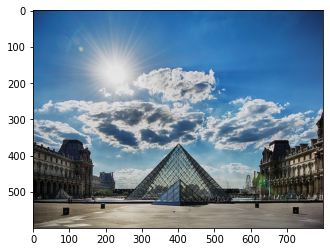

In [3]:
content_image = scipy.misc.imread("style_images/louvre.jpg")
imshow(content_image)

③ 内容图像（C）显示了卢浮宫博物馆的金字塔，周围是古老的巴黎建筑，在晴朗的天空下只有几层云。

① 正如我们在课程中所讲述的，ConvNet的底层倾向于检测诸如边缘和简单纹理之类的低层特征，而深层则倾向于检测诸如纹理之类的更复杂的高层特征。

② 我们希望生成的图像G具有与输入图像C相似的内容。假设你已选择某些层的激活来表示图像的内容。在实践中，如果在网络中间选择一个层，既不会太浅也不会太深，你将获得视觉上令人满意的结果。（完成本练习后，请随时返回并尝试使用不同的图层，以查看结果变化。）

③ 因此，假设你选择了一个特定的隐藏层使用。现在，将图像C设置为预训练的VGG网络的输入，并进行正向传播。假设$a^{(C)}$是你选择的层中的隐藏层激活。（在课程中，我们将其写为$a^{[l](C)}$，但在这里我们将删除上标$[l]$以简化表示手法。）这将是张量$n_H \times n_W \times n_C$。对图像G重复此过程：将G设置为输入，然后进行正向传播。令$a^{(G)}$为相应的隐藏层激活。我们将内容损失函数定义为：

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1}$$

④ 在这里，$n_H, n_W$和$n_C$是你选择的隐藏层的高度，宽度和通道数，并以损失的归一化术语显示。请注意$a^{(C)}$和$a^{(G)}$是与隐藏层的激活对应的。为了计算损失$J_{content}(C,G)$，将这些3D体积展开为2D矩阵更方便，如下所示。（从技术上讲，此展开步骤不需要计算$J_{content}$，但是对于之后需要进行类似操作以计算样式$J_{style}$常数的情况来说，这将是一个很好的实践。）

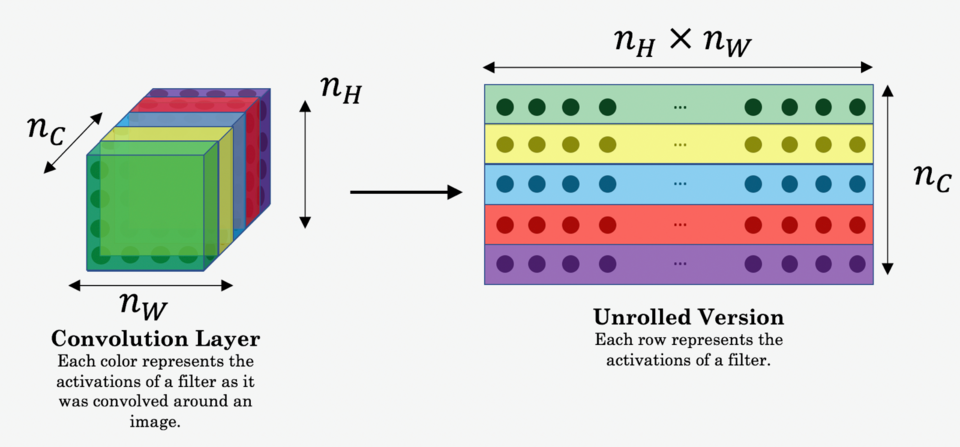

① 现在我们要使用tensorflow来实现内容代价函数，它由以下3步构成：

1. 从a_G检索尺寸。【要从张量X检索尺寸，请使用： X.get_shape().as_list()】
2. 如上图所示展开a_C和a_G。
3. 计算内容损失。

In [4]:
def compute_content_cost(a_C, a_G):
    """
    计算内容代价的函数
    
    参数：
        a_C -- tensor类型，维度为(1, n_H, n_W, n_C)，表示隐藏层中图像C的内容的激活值。
        a_G -- tensor类型，维度为(1, n_H, n_W, n_C)，表示隐藏层中图像G的内容的激活值。
    
    返回：
        J_content -- 实数，用上面的公式1计算的值。
        
    """
    
    #获取a_G的维度信息
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #对a_C与a_G从3维降到2维
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    #计算内容代价
    #J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content

In [5]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
    
    test.close()

J_content = 6.7655935


② 你应该记住：

 - 内容损失需要对神经网络进行隐藏层激活，并计算$a^{(C)}$和$a^{(G)}$之间的差异。
 - 当我们在最小化内容损失时，这将有助于确保$G$具有与$C$类似的内容。

## 3.2 计算风格损失

① 我们将使用以下样式图像作为示例运行：

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


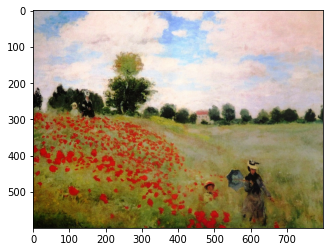

In [6]:
style_image = scipy.misc.imread("style_images/monet_800600.jpg")

imshow(style_image)

② 这幅画以印象派的风格绘制。

③让我们看看如何定义“风格”常数函数$J_{style}(S,G)$。

### 3.2.1 风格矩阵

① 风格矩阵也称为“语法矩阵”。在线性代数中，向量$(v_{1},\dots ,v_{n})$的集合的Gram矩阵G是点积的矩阵，其项是${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})}$。换句话说，$G_{ij}$比较$v_i$与$v_j$的相似度：如果它们非常相似，则它们会具有较大的点积，因此$G_{ij}$也会较大。

② 请注意，此处使用的变量名称存在冲突。我们遵循文献中使用的通用术语，但是$G$用于表示风格矩阵（或Gram矩阵）也表示生成的图像。我们将从上下文中确保清楚$G$的指代。

③ 在NST中，可以通过将“展开的”滤波器矩阵与其转置相乘来计算风格矩阵：

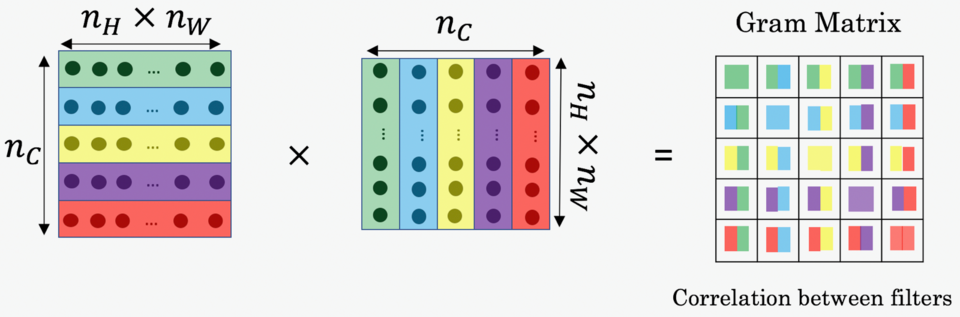

④ 结果是维度为$(n_C,n_C)$的矩阵，其中$n_C$是滤波器的数量。值$G_{ij}$衡量滤波器$i$的激活与滤波器$j$的激活的相似度。

② 语法矩阵的一个重要部分是对角元素（例如$G_{ii}$）也可以衡量滤波器$i$的活跃程度。例如，假设滤波器$i$正在检测图像中的垂直纹理。然后$G_{ii}$衡量整个图像中垂直纹理的普遍程度：如果$G_{ii}$大，则意味着图像具有很多垂直纹理。

③ 通过捕获不同类型特征的普遍性($G_{ii}$)以及一起出现多少不同特征($G_{ii}$)，样式矩阵$G$可以衡量图像的样式。

① 下面使用TensorFlow实现一个计算矩阵A的语法矩阵的函数。

② 公式为：A的语法矩阵为$G_A = AA^T$。

In [7]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###

    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 风格损失

① 生成风格矩阵（Gram矩阵）后，你的目标是使"style"图像S的Gram矩阵和生成的图像G的Gram矩阵之间的距离最小。

② 现在，我们仅使用单个隐藏层$a^{[l]}$，该层的相应的风格损失定义为：

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2}$$

③ 其中$G^{(S)}$和$G^{(G)}$分别是“风格”图像和“生成的”图像的语法矩阵，使用针对网络中特定的隐藏层的激活来计算。

④ 下面我们将计算单层的风格损失，实现此函数的步骤是：

1. 从隐藏层激活a_G中检索尺寸。【要从张量X检索尺寸，请使用：X.get_shape().as_list()】
2. 如上图所示，将隐藏层激活a_S和a_G展开为2D矩阵。
3. 计算图像S和G的风格矩阵。（使用以前编写的函数）
4. 计算风格损失。

In [9]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
     ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,shape=(n_H* n_W,n_C))
    a_G = tf.reshape(a_G,shape=(n_H* n_W,n_C))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer =tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*(n_C*n_C)*(n_W * n_H) * (n_W * n_H))

    ### END CODE HERE ###
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


### 3.2.3 风格权重

① 到目前为止，你仅从一层捕获了风格特征。如果我们从几个不同的层次“合并”风格损失，我们将获得更好的结果。

② 完成此练习后，请随时返回并尝试不同的权重，以查看它如何更改生成的图像$G$。

③ 但现在而言，这是一个合理的默认值。

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

① 你可以如下组合不同层的风格损失：$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$

 - $\lambda^{[l]}$的值在STYLE_LAYERS中给出。

② 我们已经实现了compute_style_cost（...）函数。它只是简单地多次调用你的compute_layer_style_cost（...），并使用STYLE_LAYERS中的值对结果进行加权。

③ 请仔细阅读以确保你了解它在做什么。

1. 从STYLE_LAYERS循环（layer_name，coeff）：  
   a. 选择当前层的输出张量 例如，要从层"conv1_1"中调用张量，你可以这样做：out = model["conv1_1"]  
  b. 通过在张量"out"上运行会话，从当前层获取style图像的风格  
  c. 获取一个表示当前层生成的图像风格的张量。 这只是"out"。  
  d. 现在，你拥有两种风格。使用上面实现的函数计算当前层的style_cost  
  e. 将当前层的（style_cost x coeff）添加到整体风格损失（J_style）中  
2. 返回J_style，它现在应该是每层的（style_cost x coeff）之和。

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
   
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

注意：在上述for循环的内部循环中，a_G是张量，尚未进行求值。当我们在下面的model_nn（）中运行TensorFlow计算图时，它将在每次迭代时进行评估和更新。

① 你如何选择每一层的系数？较深的层捕获更复杂的特征，并且较深的层中的特征在图像中相对于彼此而言定位较少。

② 因此，如果希望生成的图像柔和地跟随风格图像，请尝试为较深的层选择较大的权重，为第一层选择较小的权重。

③ 相反，如果希望生成的图像强烈遵循风格图像，请尝试为较低的层选择较小的权重，为第一层选择较大的权重。

④ 你应该记住：

 - 可以使用隐藏层激活的Gram矩阵表示图像的风格。但是，结合多个不同层的语法矩阵表示，我们可以获得更好的结果。这与内容表示法相反，后者通常仅使用一个隐藏层就足够了。
 - 最小化风格损失将导致图像$G$遵循图像$S$的风格。

## 3.3 定义优化的总损失

① 最后，让我们创建一个损失函数，以最小化风格和内容损失。公式为：

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

② 下面实现总损失函数，其中包括内容损失和风格损失。

In [13]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content+beta*J_style
    ### END CODE HERE ###

    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


③ 你应该记住：

 - 总损失是内容损失$J_{content}(C,G)$和风格损失$J_{style}(S,G)$的线性组合。
 - $\alpha$和$\beta$是控制内容和风格之间相对权重的超参数

# 4. 实现神经风格迁移

① 最后，让我们将所有内容组合在一起以实现神经风格迁移！

② 该程序必须执行以下操作：

 1. 创建一个交互式会话
 2. 加载内容图像
 3. 加载风格图像
 4. 随机初始化要生成的图像
 5. 加载VGG16模型
 6. 构建TensorFlow计算图：
    - 通过VGG16模型运行内容图像并计算内容损失
    - 通过VGG16模型运行风格图像并计算风格损失
    - 计算总损失
    - 定义优化器和学习率
 7. 初始化TensorFlow图，并运行大量迭代，然后在每个步骤更新生成的图像。

① 你之前已经实现了总损失$J(G)$，我们现在将设置TensorFlow来针对$G$进行优化。

② 为此，你的程序必须重置计算图并使用"Interactive Session"。

③ 与常规会话不同，交互式会话将启动自身作为默认会话以构建计算图。

④ 这使你可以运行变量而无需经常引用会话对象，从而简化了代码。

① 让我们开始交互式会话。

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

② 让我们加载，重塑和标准化我们的“内容”图像（卢浮宫博物馆图片）：

In [16]:
content_image = scipy.misc.imread("style_images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


③ 加载，重塑和标准化我们的“风格”图像（克劳德·莫奈的画）：

In [17]:
style_image = scipy.misc.imread("style_images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


④ 现在，我们将“生成的”图像初始化作为从content_image创建的噪声图像。

⑤ 通过将生成图像的像素初始化为主要是噪声但仍与内容图像稍微相关的像素，这将有助于生成的图像的内容更快速地匹配“内容”图像的内容。（可以在nst_utils.py中查看generate_noise_image（...）的详细信息；为此，请在此Jupyter笔记本的左上角单击"File-->Open..."）

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


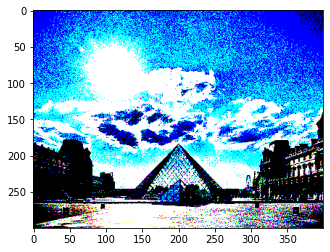

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

⑥ 接下来，如前面所述，让我们加载VGG16模型。

In [19]:
model = load_vgg_model("datasets/imagenet-vgg-verydeep-19.mat")

⑦ 为了获得计算内容损失的程序，我们现在将a_C和a_G分配为适当的隐藏层激活。我们将使用conv4_2层来计算内容损失。下面的代码执行以下操作：

 1. 将内容图像分配为VGG模型的输入。
 2. 将a_C设置为张量，为层"conv4_2"提供隐藏层激活。
 3. 设置a_G为张量，为同一层提供隐藏层激活。
 4. 使用a_C和a_G计算内容损失。

In [20]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

⑧ 注意：此时，a_G是张量，尚未验证。当我们在下面的model_nn（）中运行Tensorflow计算图时，它将在每次迭代时进行确认和更新。

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

⑨ 现在你有了J_content和J_style，通过调用total_cost()计算总损失J。 使用alpha = 10 和 beta = 40。

In [22]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

⑩ 你之前已经学习了如何在TensorFlow中设置Adam优化器。我们在这里使用2.0的学习率。

In [23]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

① 实现model_nn（）函数，该函数初始化tensorflow计算图的变量，将输入图像（初始生成的图像）作为VGG16模型的输入，并运行train_step进行训练步骤。

In [24]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###

    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    generated_image=sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###

    for i in range(num_iterations):

        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###

        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("style_out/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('style_out/generated_image.jpg', generated_image)
    
    return generated_image

② 运行以下单元格以生成艺术图像。每运行20次迭代在CPU上大约需要3分钟，但是在大约140次迭代后你开始观察到好的结果。通常使用GPU训练神经风格迁移。

In [25]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 4936884000.0
content cost = 7881.8486
style cost = 123420136.0
Iteration 20 :
total cost = 931826750.0
content cost = 15150.493
style cost = 23291882.0
Iteration 40 :
total cost = 476986140.0
content cost = 16801.93
style cost = 11920453.0
Iteration 60 :
total cost = 306919000.0
content cost = 17397.312
style cost = 7668626.0
Iteration 80 :
total cost = 224318260.0
content cost = 17652.945
style cost = 5603543.0
Iteration 100 :
total cost = 177694180.0
content cost = 17884.285
style cost = 4437883.0
Iteration 120 :
total cost = 147150240.0
content cost = 18051.762
style cost = 3674243.0
Iteration 140 :
total cost = 125385880.0
content cost = 18219.416
style cost = 3130092.2
Iteration 160 :
total cost = 108910856.0
content cost = 18357.244
style cost = 2718182.0
Iteration 180 :
total cost = 95987560.0
content cost = 18498.143
style cost = 2395064.5


array([[[[ -45.111946 ,  -71.61423  ,   51.657806 ],
         [ -24.518774 ,  -44.044056 ,   30.028664 ],
         [ -39.597336 ,  -31.46476  ,   13.784161 ],
         ...,
         [ -24.57311  ,  -10.691683 ,   14.500211 ],
         [ -28.690565 ,   -5.3127546,   23.614086 ],
         [ -40.481472 ,   -6.519434 ,   49.788063 ]],

        [[ -58.478497 ,  -52.90091  ,   26.369766 ],
         [ -32.89404  ,  -32.55271  ,   -1.4367126],
         [ -26.407204 ,  -31.807579 ,   15.714277 ],
         ...,
         [ -25.301926 ,  -10.115221 ,   24.489286 ],
         [ -20.153297 ,  -20.943392 ,   12.3595085],
         [ -39.02841  ,  -11.312411 ,    9.401995 ]],

        [[ -50.359737 ,  -50.64061  ,   15.493833 ],
         [ -37.311485 ,  -42.09216  ,   -6.2187133],
         [ -33.809223 ,  -25.81031  ,    5.8312654],
         ...,
         [ -12.074668 ,  -41.988308 ,   10.096618 ],
         [ -13.818565 ,  -24.787169 ,   14.64641  ],
         [ -23.706432 ,  -21.866766 ,   12.507955 ]],

③ 你完成了！转到"/output"目录以查看所有已保存的图像。打开"generated_image"以查看生成的图像！

④ 你应该看到下面显示的图像：

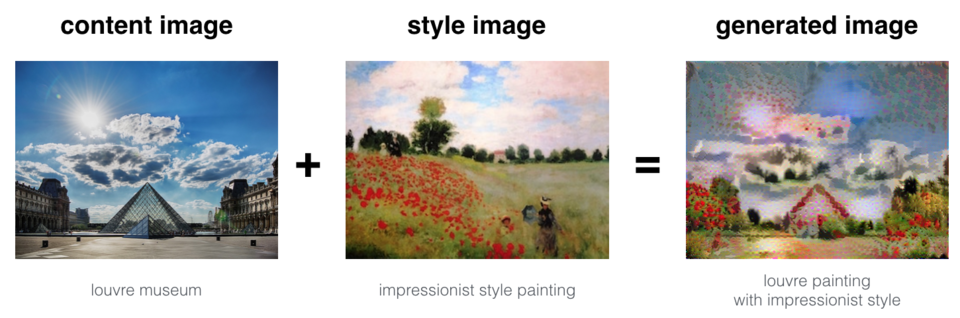

⑤ 我们不想让你等待太久才能看到初始结果，因此已相应地设置了超参数。

⑥ 为了获得最佳效果，较长的优化算法（可能以较小的学习率）运行效果更好。

⑦ 完成并提交此作业后，建议你返回并使用此笔记本进行更多操作，看看是否可以生成外观更好的图像。

⑧ 以下是一些其他示例：

 - 梵高（星空）风格的波斯波利斯（伊朗）古城的美丽废墟

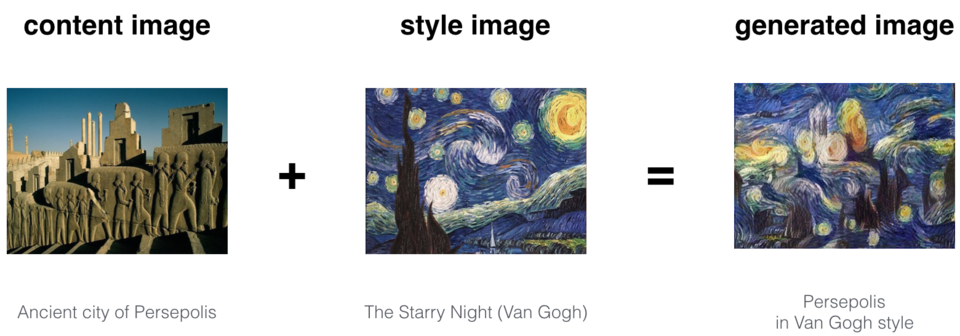

 - 伊斯帕汗陶瓷风格的居鲁士大帝之墓

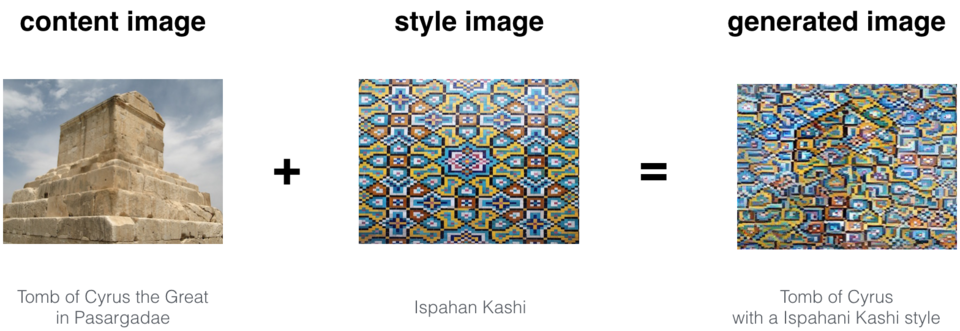

 - 具有抽象蓝色液体绘画风格的湍流科学研究。

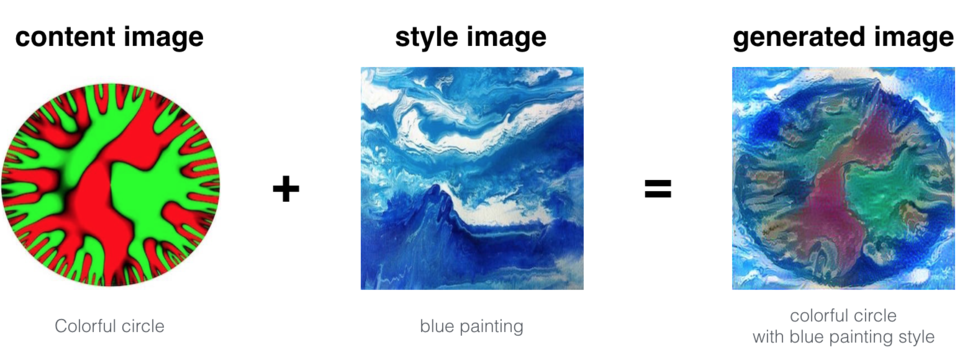

# 5. 总结

① 恭喜你出色地完成这项任务！现在，你可以使用“神经风格迁移”生成艺术图像。

② 这也是你第一次建立模型，在该模型中，优化算法将更新像素值而不是神经网络的参数。

③ 深度学习有许多不同类型的模型，这只是其中之一！

④ 你应该记住：

 - 神经风格迁移是一种算法，给定内容图像C和风格图像S可以生成艺术图像
 - 它使用基于预训练的ConvNet的特征（隐藏层激活）。
 - 使用一个隐藏层的激活来计算内容损失函数。
 - 使用该层激活的Gram矩阵计算一层的风格损失函数。使用几个隐藏层可以获得整体风格损失函数。
 - 优化总损失函数以合成新图像。

⑤ 神经风格迁移算法源于Gatys et al. (2015)。 Harish Narayanan和Github用户"log0"也写了很多精湛的文章，我们从中汲取了灵感。

⑥ 此实现中使用的预训练网络是VGG网络，这是Simonyan和Zisserman（2015）的工作成果。预先训练的权重来自MathConvNet团队的工作。